In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import math
import gc
import pprint

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# LGBM

##### 참고 : https://injo.tistory.com/48?category=1068433

GMB(Gradient Boosting Machine) 이란? 틀린부분에 가중치를 더하면서 진행하는 알고리즘

## Light GBM의 파라미터에 대해?
#### LGBM의 경우 복잡한 것은 파라미터 튜닝입니다. Light GBM은 100개 이상의 파라미터를 커버하고 있기 때문입니다.

#### Light GBM의 가장 베이직한 파라미터를 아는 것이 구현 시 매우 중요합니다. 

 

 

max_depth : Tree의 최대 깊이를 말합니다. 이 파라미터는 모델 과적합을 다룰 때 사용됩니다. 만약 여러분의 모델이 과적합된 것 같다고 느끼신다면 제 조언은 max_depth 값을 줄이라는 것입니다.

 

min_data_in_leaf : Leaf가 가지고 있는 최소한의 레코드 수입니다. 디폴트값은 20으로 최적 값입니다. 과적합을 해결할 때 사용되는 파라미터입니다.

 

feature_fraction : Boosting (나중에 다뤄질 것입니다) 이 랜덤 포레스트일 경우 사용합니다. 0.8 feature_fraction의 의미는 Light GBM이 Tree를 만들 때 매번 각각의 iteration 반복에서 파라미터 중에서 80%를 랜덤하게 선택하는 것을 의미합니다.

 

bagging_fraction : 매번 iteration을 돌 때 사용되는 데이터의 일부를 선택하는데 트레이닝 속도를 높이고 과적합을 방지할 때 주로 사용됩니다.

 

early_stopping_round : 이 파라미터는 분석 속도를 높이는데 도움이 됩니다. 모델은 만약 어떤 validation 데이터 중 하나의 지표가 지난 early_stopping_round 라운드에서 향상되지 않았다면 학습을 중단합니다. 이는 지나친 iteration을 줄이는데 도움이 됩니다.

 

lambda : lambda 값은 regularization 정규화를 합니다. 일반적인 값의 범위는 0 에서 1 사이입니다.

min_gain_to_split : 이 파라미터는 분기하기 위해 필요한 최소한의 gain을 의미합니다. Tree에서 유용한 분기의 수를 컨트롤하는데 사용됩니다.

 

max_cat_group : 카테고리 수가 클 때, 과적합을 방지하는 분기 포인트를 찾습니다. 그래서 Light GBM 알고리즘이 카테고리 그룹을 max_cat_group 그룹으로 합치고 그룹 경계선에서 분기 포인트를 찾습니다. 디폴트 값은 64 입니다.

 

Task : 데이터에 대해서 수행하고자 하는 임무를 구체화합니다. train 트레이닝일 수도 있고 predict 예측일 수도 있습니다.

 

application : 가장 중요한 파라미터로, 모델의 어플리케이션을 정하는데 이것이 regression 회귀분석 문제인지 또는

classification 분류 문제인지를 정합니다. Light GBM에서 디폴트는 regression 회귀분석 모델입니다.

- regression: 회귀분석
- binary: 이진 분류
- multiclass: 다중 분류
- boosting : 실행하고자 하는 알고리즘 타입을 정의합니다. 디폴트값은 gdbt 입니다.



- gdbt : Traditional Gradient Boosting Decision Tree
- rf : Random Forest
- dart : Dropouts meet Multiple Additive Regression Trees
- goss : Gradient-based One-Side Sampling
- num_boost_round : boosting iteration 수로 일반적으로 100 이상입니다.

 

learning_rate : 최종 결과에 대한 각각의 Tree에 영향을 미치는 변수입니다. GBM은 초기의 추정값에서 시작하여 각각의Tree 결과를 사용하여 추정값을 업데이트 합니다. 학습 파라미터는 이러한 추정에서 발생하는 변화의 크기를 컨트롤합니다. 일반적인 값은 0.1, 0.001, 0.003 등등이 있습니다.

 

num_leaves : 전체 Tree의 leave 수 이고, 디폴트값은 31입니다.

device : 디폴트 값은 cpu 인데 gpu로 변경할 수도 있습니다.

 

metric : 모델을 구현할 때 손실을 정하기 때문에 중요한 변수 중에 하나입니다. regression과 classification 을 위한 일반적인 손실 값이 아래에 나와있습니다.

- mae : mean absolute error
- mse : mean squared error
- binary_logloss : loss for binary classification
- multi_logloss : loss for multi classification

## ※ Early Stopping 기능 :
    
GBM의 경우 n_estimators에 지정된 횟수만큼 학습을 끝까지 수행하지만, XGB의 경우 오류가 더 이상 개선되지 않으면 수행을 중지
n_estimators 를 200으로 설정하고, 조기 중단 파라미터 값을 50으로 설정하면, 1부터 200회까지 부스팅을 반복하다가
50회를 반복하는 동안 학습오류가 감소하지 않으면 더 이상 부스팅을 진행하지 않고 종료합니다.
(가령 100회에서 학습오류 값이 0.8인데 101~150회 반복하는 동안 예측 오류가 0.8보다 작은 값이 하나도 없으면 부스팅을 종료)

In [47]:
train=pd.read_csv("Train.csv")
test=pd.read_csv("Test.csv")

In [48]:
train=train.drop('inst_id',axis=1)
train=train.drop('instkind_nan',axis=1)
test=test.drop('inst_id',axis=1)
test=test.drop('instkind_nan',axis=1)

In [49]:
train.head(5)

,OC,sido_choongchung,sido_gangwon,sido_gyeongin,sido_gyeongsang,sido_jeonra,sido_seoul,instkind_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,bedCount_class
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,22.162515,0.000000,22.099796,21.433189,16.566138,16.539187,16.398469,17.269990,19.232365,20.735886,20.720935,19.968362,16.525413,21.645374,21.582217,18.781494,0.0,20.341751,19.120425,0.000000,19.992422,19.676297,21.768639,21.126324,22.181380,0.000000,22.123814,21.447809,16.600193,17.216153,16.568091,16.749797,19.152229,20.537140,20.520624,20.076434,16.425505,21.658620,21.592994,18.798422,0.0,20.447504,19.222130,0.000000,20.099863,19.781657,21.686169,20.963246,4.143135,4.174387,0.0,3.0
1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,23.980280,9.659782,23.481393,19.521179,17.056168,16.823799,15.443340,15.495813,20.342724,19.074269,19.037270,10.917985,16.218383,19.670926,19.568364,15.878952,0.0,19.623979,19.023845,9.354666,18.934266,18.096803,18.567912,12.280544,20.078340,9.609001,19.910191,19.440285,16.978333,17.291624,15.026843,16.011168,17.025473,19.100225,19.065542,11.998936,16.044684,19.499605,19.428651,15.372413,0.0,19.505616,18.841626,9.180719,18.812726,17.568559,18.838180,12.258481,6.687109,6.701960,0.0,4.0
2,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20.727778,20.060616,19.918561,19.507228,11.240552,10.308986,0.000000,0.000000,17.549955,19.422937,19.351593,15.906875,16.747236,18.607003,18.607003,0.000000,0.0,18.341793,18.341793,0.000000,0.000000,0.000000,19.520988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.459586,0.693147,0.0,4.0
3,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25.006954,0.000000,24.981392,24.182293,20.042488,20.954034,20.902985,18.973242,20.621045,23.291406,23.168630,0.000000,21.133250,24.488628,24.369258,22.095768,0.0,24.469560,24.055180,23.713241,23.388542,22.704687,23.352064,22.880092,24.925842,0.000000,24.896486,24.114795,19.982624,21.026087,20.968110,19.204088,20.546991,23.132525,23.014845,0.000000,20.934483,24.401680,24.274484,22.088313,0.0,24.354384,23.557572,22.944579,23.755157,23.437961,23.284691,22.769775,6.498282,6.498282,0.0,4.0
4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,24.615974,0.000000,24.587275,23.920337,18.537150,21.073281,20.991191,0.000000,18.206865,22.566524,22.493677,22.134087,19.910926,24.499866,24.491560,19.219718,0.0,24.633249,24.087425,23.609762,23.767260,23.325956,18.273475,22.923325,24.596190,0.000000,24.576086,23.878565,20.208680,21.143362,21.023260,0.000000,17.301128,22.313883,22.219315,21.936761,19.908536,24.563393,24.543819,20.486709,0.0,24.663538,24.126880,23.590810,23.784786,23.370010,15.531458,22.923325,5.332719,5.288267,0.0,3.0


In [50]:
test.head(5)

,OC,sido_choongchung,sido_gyeongin,sido_gyeongsang,sido_jeju,sido_jeonra,sido_seoul,instkind_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,bedCount_class
0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,24.925341,0.000000,24.907711,24.196379,22.185153,22.312810,21.297558,18.155151,20.037430,23.978043,23.917333,20.400658,21.146200,24.595983,24.558393,20.430655,0.0,24.938218,24.717069,24.362411,23.320758,22.566842,22.563144,22.914314,24.875938,0.000000,24.860211,24.130096,22.128492,22.189377,21.179820,19.201838,20.065837,23.941738,23.887866,20.936564,20.993779,24.562759,24.497473,20.495595,0.0,24.737962,24.648885,24.338050,22.275075,22.268698,23.501178,22.914314,6.542472,6.542472,0.0,3.0
1,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.277401,0.000000,24.207354,23.540024,18.045409,21.406884,21.384125,0.000000,19.930422,22.491710,22.404503,20.309308,20.008954,25.042221,24.924767,15.319588,0.0,24.916963,24.463538,23.871719,23.907878,23.568175,23.411417,23.071090,24.348740,0.000000,24.378724,23.666511,19.071975,22.030075,21.424438,0.000000,18.389877,22.428690,22.321313,18.855256,20.144076,24.906747,24.904599,16.489659,0.0,24.932551,24.463273,23.909618,23.950510,23.630167,22.055404,0.000000,5.940171,5.918894,0.0,2.0
2,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,23.870014,21.656442,23.862557,23.181772,21.194483,21.046031,20.512693,0.000000,18.951403,23.261171,23.151533,22.716210,20.996276,24.106118,24.066351,18.748595,0.0,0.000000,24.066351,23.806220,0.000000,0.000000,0.000000,23.519657,23.929273,21.128798,23.890406,23.200767,19.279858,21.007586,20.254739,16.537481,17.461825,23.329063,23.260015,22.669705,20.621791,24.103856,24.047434,19.876620,0.0,0.000000,24.047434,23.806220,0.000000,0.000000,0.000000,23.519657,5.285888,5.225619,0.2,3.0
3,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,22.302379,21.446452,0.000000,0.000000,21.749187,22.880193,22.789032,0.000000,20.439834,24.932465,24.884536,0.000000,0.0,24.087758,23.982974,23.654559,21.779972,0.000000,24.574017,0.000000,0.000000,0.000000,0.000000,0.000000,22.327798,21.471250,0.000000,0.000000,21.775064,23.212245,23.144950,0.000000,20.480117,24.392173,24.307323,0.000000,0.0,23.217724,22.980460,22.170624,21.662855,0.000000,24.390483,0.000000,6.634633,6.634633,0.0,4.0
4,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,24.642667,0.000000,24.606025,23.857170,21.151439,0.000000,21.668651,0.000000,21.931233,22.783750,22.688744,18.519621,20.382809,24.882907,24.821652,21.999192,0.0,24.619492,23.943482,23.568302,23.908909,23.023490,23.844835,23.426431,24.495796,0.000000,24.428956,23.652653,21.312274,0.000000,22.090703,0.000000,22.252373,22.903426,22.786169,18.988265,20.701982,24.831791,24.819959,20.119500,0.0,24.506540,22.742900,21.916712,24.318498,23.784183,23.971502,23.436150,6.082219,5.955837,0.0,3.0


In [51]:
X_train = train.drop('OC', axis=1)
y_train = train['OC']

In [52]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [53]:
from lightgbm import LGBMClassifier

In [54]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings

In [55]:
# 전체 데이터셋을 학습용 80%, 테스트용 20%로 분할
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=156)

# 트리개수 400개 지정
lgbm_wrapper = LGBMClassifier(n_estimators=400, objective="binary")

In [56]:
evals = [(X_test, y_test)]

lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds =100, eval_metric='logloss', eval_set=evals, verbose=True)

preds=lgbm_wrapper.predict(X_test)

[1]	valid_0's binary_logloss: 0.150852
[2]	valid_0's binary_logloss: 0.154028
[3]	valid_0's binary_logloss: 0.146277
[4]	valid_0's binary_logloss: 0.146374
[5]	valid_0's binary_logloss: 0.148023
[6]	valid_0's binary_logloss: 0.147199
[7]	valid_0's binary_logloss: 0.146126
[8]	valid_0's binary_logloss: 0.145246
[9]	valid_0's binary_logloss: 0.148102
[10]	valid_0's binary_logloss: 0.146956
[11]	valid_0's binary_logloss: 0.148833
[12]	valid_0's binary_logloss: 0.15085
[13]	valid_0's binary_logloss: 0.151554
[14]	valid_0's binary_logloss: 0.1534
[15]	valid_0's binary_logloss: 0.152045
[16]	valid_0's binary_logloss: 0.152887
[17]	valid_0's binary_logloss: 0.15214
[18]	valid_0's binary_logloss: 0.153398
[19]	valid_0's binary_logloss: 0.153271
[20]	valid_0's binary_logloss: 0.152797
[21]	valid_0's binary_logloss: 0.154985
[22]	valid_0's binary_logloss: 0.15803
[23]	valid_0's binary_logloss: 0.158389
[24]	valid_0's binary_logloss: 0.159609
[25]	valid_0's binary_logloss: 0.158549
[26]	valid_0's

In [57]:
def get_clf_eval(y_test, y_pred):
    
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))

In [58]:
get_clf_eval(y_test, preds)

오차행렬:
 [[ 0  2]
 [ 0 59]]

정확도: 0.9672
정밀도: 0.9672
재현율: 1.0000
F1: 0.9833


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

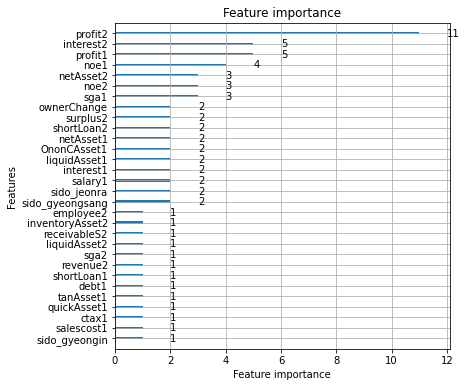

In [59]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plot_importance(lgbm_wrapper, ax=ax)

### 트리개수 수정

In [60]:
# 전체 데이터셋을 학습용 80%, 테스트용 20%로 분할
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=156)

# 트리개수 200개 지정
lgbm_wrapper = LGBMClassifier(n_estimators=200) # 과적합이 의심되어 절반으로 줄여서 시도

In [61]:
evals = [(X_test, y_test)]

lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds =100, eval_metric='logloss', eval_set=evals, verbose=True)

preds=lgbm_wrapper.predict(X_test)

[1]	valid_0's binary_logloss: 0.124938
[2]	valid_0's binary_logloss: 0.127941
[3]	valid_0's binary_logloss: 0.132192
[4]	valid_0's binary_logloss: 0.131585
[5]	valid_0's binary_logloss: 0.134793
[6]	valid_0's binary_logloss: 0.136811
[7]	valid_0's binary_logloss: 0.141446
[8]	valid_0's binary_logloss: 0.143399
[9]	valid_0's binary_logloss: 0.144727
[10]	valid_0's binary_logloss: 0.146682
[11]	valid_0's binary_logloss: 0.147131
[12]	valid_0's binary_logloss: 0.148085
[13]	valid_0's binary_logloss: 0.148478
[14]	valid_0's binary_logloss: 0.151438
[15]	valid_0's binary_logloss: 0.154342
[16]	valid_0's binary_logloss: 0.155525
[17]	valid_0's binary_logloss: 0.157242
[18]	valid_0's binary_logloss: 0.157908
[19]	valid_0's binary_logloss: 0.159037
[20]	valid_0's binary_logloss: 0.161837
[21]	valid_0's binary_logloss: 0.165425
[22]	valid_0's binary_logloss: 0.167211
[23]	valid_0's binary_logloss: 0.167749
[24]	valid_0's binary_logloss: 0.166237
[25]	valid_0's binary_logloss: 0.169699
[26]	vali

In [62]:
get_clf_eval(y_test, preds) # 아까보다 정확도가 조금 더 올라감

오차행렬:
 [[ 0  1]
 [ 0 47]]

정확도: 0.9792
정밀도: 0.9792
재현율: 1.0000
F1: 0.9895


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

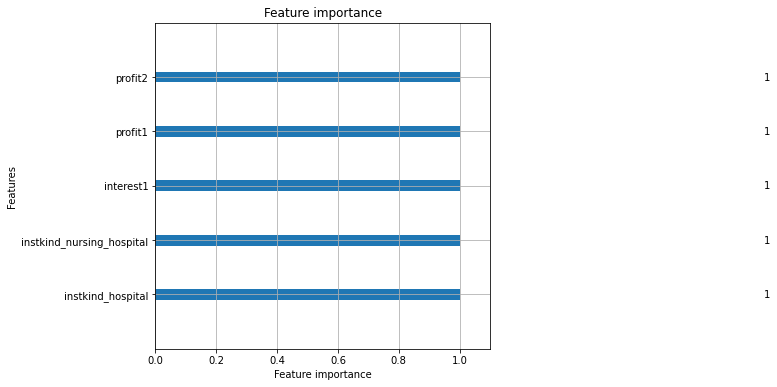

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_importance(lgbm_wrapper, ax=ax)

## 분할율수정

In [64]:
# 전체 데이터셋을 학습용 85%, 테스트용 15%로 분할
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=156)

# 트리개수 400개 지정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

In [65]:
evals = [(X_test, y_test)]


# eval_metric : 사용할 값은, 회귀, 분류, 순위 등의 정밀도에 따라 부여한다.
## rmse for regression, logloss for classification, error, mlogloss  etc.

lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds =100, eval_metric='logloss', eval_set=evals, verbose=True)

preds=lgbm_wrapper.predict(X_test)

[1]	valid_0's binary_logloss: 0.321459
[2]	valid_0's binary_logloss: 0.318271
[3]	valid_0's binary_logloss: 0.319916
[4]	valid_0's binary_logloss: 0.322882
[5]	valid_0's binary_logloss: 0.330726
[6]	valid_0's binary_logloss: 0.326491
[7]	valid_0's binary_logloss: 0.331788
[8]	valid_0's binary_logloss: 0.333174
[9]	valid_0's binary_logloss: 0.335252
[10]	valid_0's binary_logloss: 0.344262
[11]	valid_0's binary_logloss: 0.352304
[12]	valid_0's binary_logloss: 0.353991
[13]	valid_0's binary_logloss: 0.355265
[14]	valid_0's binary_logloss: 0.36408
[15]	valid_0's binary_logloss: 0.372674
[16]	valid_0's binary_logloss: 0.381745
[17]	valid_0's binary_logloss: 0.383062
[18]	valid_0's binary_logloss: 0.38575
[19]	valid_0's binary_logloss: 0.388732
[20]	valid_0's binary_logloss: 0.398218
[21]	valid_0's binary_logloss: 0.405916
[22]	valid_0's binary_logloss: 0.407977
[23]	valid_0's binary_logloss: 0.409664
[24]	valid_0's binary_logloss: 0.412428
[25]	valid_0's binary_logloss: 0.415062
[26]	valid_

In [66]:
get_clf_eval(y_test, preds)

오차행렬:
 [[ 0  3]
 [ 0 26]]

정확도: 0.8966
정밀도: 0.8966
재현율: 1.0000
F1: 0.9455


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

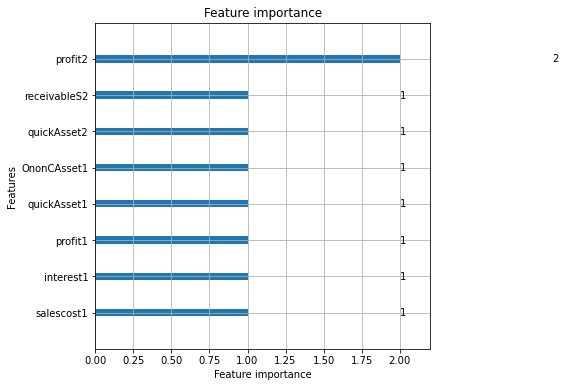

In [67]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_importance(lgbm_wrapper, ax=ax)

정확도 낮아짐

In [74]:
# 전체 데이터셋을 학습용 80%, 테스트용 20%로 분할
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=156)

# 트리개수 200개 지정
lgbm_wrapper = LGBMClassifier(n_estimators=200) # 과적합이 의심되어 절반으로 줄여서 시도

evals = [(X_test, y_test)]

lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds = 105, eval_metric='logloss', eval_set=evals, verbose=True)

preds=lgbm_wrapper.predict(X_test)

[1]	valid_0's binary_logloss: 0.0469417
[2]	valid_0's binary_logloss: 0.0490743
[3]	valid_0's binary_logloss: 0.0470787
[4]	valid_0's binary_logloss: 0.048671
[5]	valid_0's binary_logloss: 0.0500305
[6]	valid_0's binary_logloss: 0.0515023
[7]	valid_0's binary_logloss: 0.0537643
[8]	valid_0's binary_logloss: 0.0509669
[9]	valid_0's binary_logloss: 0.0519066
[10]	valid_0's binary_logloss: 0.0491081
[11]	valid_0's binary_logloss: 0.049807
[12]	valid_0's binary_logloss: 0.0478901
[13]	valid_0's binary_logloss: 0.0482347
[14]	valid_0's binary_logloss: 0.0456255
[15]	valid_0's binary_logloss: 0.04581
[16]	valid_0's binary_logloss: 0.043226
[17]	valid_0's binary_logloss: 0.0442298
[18]	valid_0's binary_logloss: 0.0443238
[19]	valid_0's binary_logloss: 0.0424526
[20]	valid_0's binary_logloss: 0.0424341
[21]	valid_0's binary_logloss: 0.0404167
[22]	valid_0's binary_logloss: 0.0383663
[23]	valid_0's binary_logloss: 0.0361598
[24]	valid_0's binary_logloss: 0.0359474
[25]	valid_0's binary_logloss:

In [75]:
get_clf_eval(y_test, preds) # 아까보다 정확도가 조금 더 올라감

오차행렬:
 [[17]]

정확도: 1.0000
정밀도: 1.0000
재현율: 1.0000
F1: 1.0000
